# Hypertrophic Cardiomyopathy Genes Cross-Validation
##### Selin Kubali
##### 12/13/2023
## Goal
Find out whether we can distinguish the HCM risk of bottom 25% and top 25% of missense and deleterious variant carriers in key hypertrophic cardiomyopathy-related genes.

#### How the code functions
Use cross-validation to fit a Cox-PH model and predict hazard scores. Then isolate the bottom 25% and top 25% of carriers by hazard score and calculate whether there is a statistically significant difference in HCM between them use the Mann-Whitney U test.

Cross-validation is done by splitting on variant data, to ensure there are an equal number of variants in each fold and prevent overfitting on high-frequency variants.

#### Inputs
Lifelines files - from running generate_extracts_gnomAD.ipynb on UKBiobank in Cassa Lab Shared Project/selected_genes/hcm/notebooks. Stored in Cassa Lab Shared Project/selected_genes/hcm/lifelines_data. 
Variant data files - from running vep_processing.ipynb on UKBiobank in Cassa Lab Shared Project/selected_genes/hcm/notebooks. Stored in Cassa Lab Shared Project/selected_genes/hcm/parsed_vep_files

#### Note
Two HCM related genes - DES and PLN - were eliminated for having too few variants to converge.
PTPN11, TNNI3, and TTR each have few cases of HCM with missense or deleterious variants, which may harm convergence.

In [212]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from sklearn.model_selection import KFold
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt 

In [218]:
def cross_val(gene):
        cph = CoxPHFitter(penalizer=0.001)
        # load lifelines file
        file_name=gene+'.csv'
        lifelines_data = pd.read_csv("/Users/uriel/Downloads/work_temp/cross_val_lifelines/"+file_name, dtype={
                'is_family_hist':'boolean',
                'is_hcm':'boolean'
                })

        # load variant data file
        file_name=gene+'.csv'
        variant_data = pd.read_csv("/Users/uriel/Downloads/work_temp/variant_files/"+file_name)


        clinvar_df = pd.read_csv("/Users/uriel/Downloads/work_temp/variant_summary.txt", sep = '\t')
        clinvar_df = clinvar_df[clinvar_df['Assembly'] == 'GRCh38']
        clinvar_df = clinvar_df.rename(columns={"Chromosome": "Chrom", "Start": "Pos", "ReferenceAlleleVCF": "Ref", "AlternateAlleleVCF": "Alt"})
        clinvar_df = clinvar_df[["Name", "Chrom", "Pos", "Ref", "Alt", "ClinicalSignificance"]]
        clinvar_variant_df = pd.merge(variant_data, clinvar_df, how = 'left', on = ['Pos', 'Ref', 'Alt'])
        clinvar_variant_df = clinvar_variant_df.rename(columns={"Name_x": "Name"})
        clinvar_variant_df = clinvar_variant_df[["Name", "ClinicalSignificance"]]
        lifelines_data_with_clin_sign = pd.merge(clinvar_variant_df, lifelines_data, how="right", on = ['Name'])
        lifelines_data_with_clin_sign = lifelines_data_with_clin_sign.drop(['Name', 'Carrier', 'index', 'am_pathogenicity'], axis = 1)

        


        variant_data = variant_data[['Name']]
        variant_data['var_index'] = variant_data.index





        # set lifelines data index to variant data index
        lifelines_data = variant_data.merge(lifelines_data, how="outer")
        lifelines_data.set_index("var_index")
        

        # clean lifelines file; set pathogenicity for deleterious variants to 1
        lifelines_data.loc[lifelines_data['deleterious'] == 1, 'am_pathogenicity'] = 1
        #lifelines_data.loc[lifelines_data['synonymous_variant'] == 1, 'am_pathogenicity'] = 0
        lifelines_data = lifelines_data.drop(['Name','Carrier', 'index', 'am_pathogenicity'], axis = 1)
        lifelines_data = lifelines_data[(lifelines_data['deleterious'] == True) | (lifelines_data['missense_variant'] == True)]
        lifelines_data = lifelines_data.drop(['deleterious','missense_variant', 'synonymous_variant'], axis = 1)
        lifelines_data = lifelines_data.dropna()

        #



        # cross validation: split up phenotypic data file based on variant file index
        kf = KFold(n_splits=5, shuffle=True, random_state=1)
        testing_set = []
        for train_idx, test_idx in kf.split(variant_data):
                
                train = lifelines_data[lifelines_data['var_index'].isin(train_idx)]
                test = lifelines_data[lifelines_data['var_index'].isin(test_idx)]

                train = train.drop(['var_index'], axis=1)
                test = test.drop(['var_index'], axis=1)

                # fit CPH and add hazard scores
                cph.fit(train, duration_col="duration", event_col="is_hcm", fit_options = {"step_size":0.1})
                hazard_scores_fold = cph.predict_partial_hazard(test)
                test['hazard'] = hazard_scores_fold
                testing_set.append(test)



        # create new lifelines_data df by joining all testing sets
        lifelines_data = pd.concat([df for idx, df in enumerate(testing_set)]) 
        lifelines_data = pd.merge(lifelines_data, lifelines_data_with_clin_sign, how = 'left')
        
        return lifelines_data
    

In [219]:

def find_params(gene):
        thresholds_list =  list(range(1, 101))



        p_vals = {}
        hazard_ratios = {}

        
        lifelines_data = cross_val(gene)
        


        # filter for patients with lowest 25% and highest 25% hazard scores

        for i in thresholds_list:
                percentiles = np.percentile(lifelines_data['hazard'], [i])
                bottom = lifelines_data[lifelines_data['hazard'] < percentiles[0]]
                top = lifelines_data[lifelines_data['hazard'] >= percentiles[0]]


                bottom.loc[:,'is_hcm'] = np.where(bottom['is_hcm'] == True, 1, 0)
                top.loc[:,'is_hcm'] = np.where(top['is_hcm'] == True, 1, 0)
                dfA = pd.DataFrame({'E': bottom['is_hcm'], 'T': bottom['duration'], 'is_highest': 0})
                dfB = pd.DataFrame({'E': top['is_hcm'], 'T': top['duration'], 'is_highest': 1})


                df = pd.concat([dfA, dfB])

                cph = CoxPHFitter().fit(df, 'T', 'E', fit_options = {"step_size":0.1})
                hazard_ratios.update({i:cph.hazard_ratios_.at['is_highest']})

                p_vals.update({i:cph.summary['p'].at['is_highest']})



        p_adjusted = multipletests(list(p_vals.values()), alpha=0.01, method='fdr_bh')
        updated_dict = {key: new_p_val for key, new_p_val in zip(p_vals.keys(), p_adjusted[1])}

        
        return updated_dict, hazard_ratios





#### Find thresholds

In [220]:
genes = ['ACTN2', 'ALPK3', 'FLNC','MYBPC3','MYH6', 'MYH7', 'PTPN11', 'TNNI3', 'TTR']
thresholds_by_hazard_score = {}


for gene in genes:
    p_vals, hazard_ratios = find_params(gene)

    sig_p_vals = dict((k, v) for k, v in p_vals.items() if v < 0.05) # change to 0.05
    print(gene)
    print(p_vals)
    print(sig_p_vals)



    if bool(sig_p_vals) == True:
        result_dict = {key: hazard_ratios[key] for key in sig_p_vals}
        associated_hazard_threshold = max(result_dict, key=result_dict.get)
        thresholds_by_hazard_score.update({gene:associated_hazard_threshold})
    






/var/folders/8_/3b98_7m10n32rvh6mgvypgj80000gn/T/ipykernel_77080/2218620000.py:15: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  clinvar_df = pd.read_csv("/Users/uriel/Downloads/work_temp/variant_summary.txt", sep = '\t')
/Users/uriel/miniconda3/envs/default_env/lib/python3.10/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column is_highest have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['E'].astype(bool)
>>> print(df.loc[events, 'is_highest'].var())
>>> print(df.loc[~events, 'is_highest'].var())

A very low variance means that the column is_highest completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), Convergence

ACTN2
{1: 0.997458589567952, 2: 0.997458589567952, 3: 0.997458589567952, 4: 0.997458589567952, 5: 0.997458589567952, 6: 0.997458589567952, 7: 0.997458589567952, 8: 0.997458589567952, 9: 0.997458589567952, 10: 0.997458589567952, 11: 0.997458589567952, 12: 0.997458589567952, 13: 0.997458589567952, 14: 0.997458589567952, 15: 0.997458589567952, 16: 0.997458589567952, 17: 0.997458589567952, 18: 0.997458589567952, 19: 0.997458589567952, 20: 0.997458589567952, 21: 0.997458589567952, 22: 0.997458589567952, 23: 0.997458589567952, 24: 0.997458589567952, 25: 0.997458589567952, 26: 0.997458589567952, 27: 0.997458589567952, 28: 0.997458589567952, 29: 0.997458589567952, 30: 0.997458589567952, 31: 0.997458589567952, 32: 0.997458589567952, 33: 0.997458589567952, 34: 0.997458589567952, 35: 0.997458589567952, 36: 0.997458589567952, 37: 0.997458589567952, 38: 0.997458589567952, 39: 0.997458589567952, 40: 0.997458589567952, 41: 0.997458589567952, 42: 0.997458589567952, 43: 0.997458589567952, 44: 0.9974585

/var/folders/8_/3b98_7m10n32rvh6mgvypgj80000gn/T/ipykernel_77080/2218620000.py:15: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  clinvar_df = pd.read_csv("/Users/uriel/Downloads/work_temp/variant_summary.txt", sep = '\t')
/Users/uriel/miniconda3/envs/default_env/lib/python3.10/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column is_highest have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['E'].astype(bool)
>>> print(df.loc[events, 'is_highest'].var())
>>> print(df.loc[~events, 'is_highest'].var())

A very low variance means that the column is_highest completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), Convergence

ALPK3
{1: 0.9975839505993996, 2: 0.9975839505993996, 3: 0.9975839505993996, 4: 0.7740445604726908, 5: 0.6162718281438613, 6: 0.5103566228711993, 7: 0.4206761779240259, 8: 0.3467409766323975, 9: 0.2927746577636123, 10: 0.2518755458557306, 11: 0.21531650090175058, 12: 0.1841888508134578, 13: 0.15810759904934432, 14: 0.13930454830920996, 15: 0.120764735463222, 16: 0.10508314292937519, 17: 0.0927530638557152, 18: 0.08303557280507842, 19: 0.07500082375131903, 20: 0.06728881955465135, 21: 0.09221090720413436, 22: 0.08016327746238133, 23: 0.07030149053732926, 24: 0.05967787025114995, 25: 0.050882979009247035, 26: 0.04314369298631253, 27: 0.0371252124657302, 28: 0.03272676188788431, 29: 0.02862708622718463, 30: 0.02481001459430646, 31: 0.0348881121230845, 32: 0.03024141267353072, 33: 0.026417340777473253, 34: 0.022251787724005483, 35: 0.03443048626988772, 36: 0.02863511365036769, 37: 0.02481001459430646, 38: 0.020714018348366517, 39: 0.016507212173382604, 40: 0.013349979827836372, 41: 0.010986

/var/folders/8_/3b98_7m10n32rvh6mgvypgj80000gn/T/ipykernel_77080/2218620000.py:15: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  clinvar_df = pd.read_csv("/Users/uriel/Downloads/work_temp/variant_summary.txt", sep = '\t')
/Users/uriel/miniconda3/envs/default_env/lib/python3.10/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column is_highest have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['E'].astype(bool)
>>> print(df.loc[events, 'is_highest'].var())
>>> print(df.loc[~events, 'is_highest'].var())

A very low variance means that the column is_highest completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), Convergence

FLNC
{1: 0.436198078881309, 2: 0.9024042982558146, 3: 0.5449433158431032, 4: 0.8407067929950317, 5: 0.9972401598331023, 6: 0.8255053529138529, 7: 0.6530530881118212, 8: 0.5318094852744737, 9: 0.43271713251602534, 10: 0.6502235920477415, 11: 0.5360534750629264, 12: 0.43839221953345237, 13: 0.36150722802601043, 14: 0.29254219377955626, 15: 0.2372085949514477, 16: 0.18961393266421575, 17: 0.156404935928736, 18: 0.12904941142306844, 19: 0.10696066431716017, 20: 0.09064104897184286, 21: 0.14092582942273862, 22: 0.116723475465566, 23: 0.18282644156473224, 24: 0.15079676470567469, 25: 0.1237339778278847, 26: 0.10599958883224961, 27: 0.08748184579106091, 28: 0.07013804925402137, 29: 0.05825082207115739, 30: 0.049914890639155614, 31: 0.042767738414818866, 32: 0.03676816584744461, 33: 0.05443066096075162, 34: 0.04651166937753174, 35: 0.07013804925402137, 36: 0.05825082207115739, 37: 0.09416192007402793, 38: 0.07730957443654776, 39: 0.06251653353603513, 40: 0.054047848290171265, 41: 0.04499717960

/var/folders/8_/3b98_7m10n32rvh6mgvypgj80000gn/T/ipykernel_77080/2218620000.py:15: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  clinvar_df = pd.read_csv("/Users/uriel/Downloads/work_temp/variant_summary.txt", sep = '\t')
/Users/uriel/miniconda3/envs/default_env/lib/python3.10/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column is_highest have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['E'].astype(bool)
>>> print(df.loc[events, 'is_highest'].var())
>>> print(df.loc[~events, 'is_highest'].var())

A very low variance means that the column is_highest completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), Convergence

MYBPC3
{1: 0.9975783932345982, 2: 0.9975783932345982, 3: 0.6903450255823893, 4: 0.4946136213121336, 5: 0.3647682136679672, 6: 0.27357698222832005, 7: 0.2062914015467672, 8: 0.16002095509691788, 9: 0.126255221407784, 10: 0.10212601149100158, 11: 0.08291705593836761, 12: 0.0676146370617952, 13: 0.05520938145458797, 14: 0.04471604845661476, 15: 0.03703612975682343, 16: 0.03084830433394995, 17: 0.02610227769583041, 18: 0.021698309361030323, 19: 0.018341642921620913, 20: 0.015647800110801528, 21: 0.013486196287868102, 22: 0.011483877042347618, 23: 0.009647590476276006, 24: 0.006616011551268218, 25: 0.005315296104009559, 26: 0.004278082866601068, 27: 0.0034124531850291836, 28: 0.0026949949739882195, 29: 0.002139006915515228, 30: 0.0017086392431043622, 31: 0.0013552450631083117, 32: 0.001087162010144276, 33: 0.0008683872062937839, 34: 0.0006991050489227092, 35: 0.0005476007196782676, 36: 0.0004099454637542059, 37: 0.000308518577935166, 38: 0.00023188303188473097, 39: 0.00017438265165312892, 4

/var/folders/8_/3b98_7m10n32rvh6mgvypgj80000gn/T/ipykernel_77080/2218620000.py:15: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  clinvar_df = pd.read_csv("/Users/uriel/Downloads/work_temp/variant_summary.txt", sep = '\t')
/Users/uriel/miniconda3/envs/default_env/lib/python3.10/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column is_highest have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['E'].astype(bool)
>>> print(df.loc[events, 'is_highest'].var())
>>> print(df.loc[~events, 'is_highest'].var())

A very low variance means that the column is_highest completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), Convergence

MYH6
{1: 0.9978702437472051, 2: 0.9978702437472051, 3: 0.9978702437472051, 4: 0.9978702437472051, 5: 0.9978702437472051, 6: 0.9978702437472051, 7: 0.9978702437472051, 8: 0.9978702437472051, 9: 0.9978702437472051, 10: 0.9978702437472051, 11: 0.9978702437472051, 12: 0.9978702437472051, 13: 0.9978702437472051, 14: 0.9978702437472051, 15: 0.9978702437472051, 16: 0.9978702437472051, 17: 0.9978702437472051, 18: 0.9978702437472051, 19: 0.9978702437472051, 20: 0.9978702437472051, 21: 0.9978702437472051, 22: 0.9978702437472051, 23: 0.9978702437472051, 24: 0.27985467896134686, 25: 0.5430637573533343, 26: 0.5053382031577223, 27: 0.46798725876198854, 28: 0.4338857520274126, 29: 0.3993366131261357, 30: 0.37031885746155896, 31: 0.3404748337967337, 32: 0.30895692025468496, 33: 0.2811291892918829, 34: 0.2671964772785175, 35: 0.24487325402876323, 36: 0.22476294586248194, 37: 0.20786383029454367, 38: 0.191219300620718, 39: 0.18352813553897487, 40: 0.1764446930043871, 41: 0.1718469915314373, 42: 0.167618

/var/folders/8_/3b98_7m10n32rvh6mgvypgj80000gn/T/ipykernel_77080/2218620000.py:15: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  clinvar_df = pd.read_csv("/Users/uriel/Downloads/work_temp/variant_summary.txt", sep = '\t')
/Users/uriel/miniconda3/envs/default_env/lib/python3.10/site-packages/lifelines/utils/__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


MYH7
{1: 0.6963782813979887, 2: 0.8153392149213173, 3: 0.5164067612172316, 4: 0.33283639068002, 5: 0.23285936647990255, 6: 0.1708392923034271, 7: 0.1306464050887549, 8: 0.09795693591135378, 9: 0.08053673783994195, 10: 0.06722975508221353, 11: 0.05796517252625247, 12: 0.09547039606080752, 13: 0.07768669887557887, 14: 0.09795693591135378, 15: 0.0786130958263044, 16: 0.09795693591135378, 17: 0.07934984740677817, 18: 0.09795693591135378, 19: 0.08041810414909652, 20: 0.10045903694331597, 21: 0.08053673783994195, 22: 0.06561515767620044, 23: 0.05222875591111443, 24: 0.04219053998051197, 25: 0.05533377675128144, 26: 0.044095891003933685, 27: 0.035471980846166165, 28: 0.02780541946206677, 29: 0.02244397813771844, 30: 0.02780541946206677, 31: 0.05796517252625247, 32: 0.07768669887557887, 33: 0.09793170736886865, 34: 0.07768669887557887, 35: 0.061812123149493095, 36: 0.05184801784077316, 37: 0.04035498544772698, 38: 0.0305715203114029, 39: 0.023652695379065454, 40: 0.02139935116379808, 41: 0.024

/var/folders/8_/3b98_7m10n32rvh6mgvypgj80000gn/T/ipykernel_77080/2218620000.py:15: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  clinvar_df = pd.read_csv("/Users/uriel/Downloads/work_temp/variant_summary.txt", sep = '\t')
/Users/uriel/miniconda3/envs/default_env/lib/python3.10/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column is_highest have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['E'].astype(bool)
>>> print(df.loc[events, 'is_highest'].var())
>>> print(df.loc[~events, 'is_highest'].var())

A very low variance means that the column is_highest completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), Convergence

PTPN11
{1: 0.9974120190898131, 2: 0.9337795241714608, 3: 0.9974120190898131, 4: 0.6718558388380506, 5: 0.6718558388380506, 6: 0.7711650219176173, 7: 0.8813935441869302, 8: 0.9337795241714608, 9: 0.9337795241714608, 10: 0.9974120190898131, 11: 0.9974120190898131, 12: 0.9974120190898131, 13: 0.9974120190898131, 14: 0.9974120190898131, 15: 0.9974120190898131, 16: 0.9974120190898131, 17: 0.9974120190898131, 18: 0.9974120190898131, 19: 0.9974120190898131, 20: 0.9974120190898131, 21: 0.9974120190898131, 22: 0.9974120190898131, 23: 0.9974120190898131, 24: 0.9974120190898131, 25: 0.9974120190898131, 26: 0.9974120190898131, 27: 0.9974120190898131, 28: 0.9974120190898131, 29: 0.9974120190898131, 30: 0.9974120190898131, 31: 0.9974120190898131, 32: 0.9974120190898131, 33: 0.9974120190898131, 34: 0.9974120190898131, 35: 0.9974120190898131, 36: 0.9974120190898131, 37: 0.9974120190898131, 38: 0.9974120190898131, 39: 0.9974120190898131, 40: 0.9974120190898131, 41: 0.9974120190898131, 42: 0.99741201908

/var/folders/8_/3b98_7m10n32rvh6mgvypgj80000gn/T/ipykernel_77080/2218620000.py:15: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  clinvar_df = pd.read_csv("/Users/uriel/Downloads/work_temp/variant_summary.txt", sep = '\t')
/Users/uriel/miniconda3/envs/default_env/lib/python3.10/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column is_highest have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['E'].astype(bool)
>>> print(df.loc[events, 'is_highest'].var())
>>> print(df.loc[~events, 'is_highest'].var())

A very low variance means that the column is_highest completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), Convergence

TNNI3
{1: 0.999764163720577, 2: 0.999764163720577, 3: 0.999764163720577, 4: 0.999764163720577, 5: 0.999764163720577, 6: 0.999764163720577, 7: 0.999764163720577, 8: 0.999764163720577, 9: 0.999764163720577, 10: 0.999764163720577, 11: 0.999764163720577, 12: 0.999764163720577, 13: 0.999764163720577, 14: 0.999764163720577, 15: 0.999764163720577, 16: 0.999764163720577, 17: 0.999764163720577, 18: 0.999764163720577, 19: 0.999764163720577, 20: 0.999764163720577, 21: 0.999764163720577, 22: 0.999764163720577, 23: 0.999764163720577, 24: 0.999764163720577, 25: 0.999764163720577, 26: 0.999764163720577, 27: 0.999764163720577, 28: 0.999764163720577, 29: 0.999764163720577, 30: 0.999764163720577, 31: 0.999764163720577, 32: 0.999764163720577, 33: 0.999764163720577, 34: 0.999764163720577, 35: 0.999764163720577, 36: 0.999764163720577, 37: 0.999764163720577, 38: 0.999764163720577, 39: 0.999764163720577, 40: 0.999764163720577, 41: 0.999764163720577, 42: 0.999764163720577, 43: 0.999764163720577, 44: 0.9997641

/var/folders/8_/3b98_7m10n32rvh6mgvypgj80000gn/T/ipykernel_77080/2218620000.py:15: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  clinvar_df = pd.read_csv("/Users/uriel/Downloads/work_temp/variant_summary.txt", sep = '\t')
/Users/uriel/miniconda3/envs/default_env/lib/python3.10/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column is_highest have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['E'].astype(bool)
>>> print(df.loc[events, 'is_highest'].var())
>>> print(df.loc[~events, 'is_highest'].var())

A very low variance means that the column is_highest completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), Convergence

TTR
{1: 0.9973808181132177, 2: 0.9973808181132177, 3: 0.9973808181132177, 4: 0.9973808181132177, 5: 0.9973808181132177, 6: 0.9973808181132177, 7: 0.9973808181132177, 8: 0.9973808181132177, 9: 0.9973808181132177, 10: 0.9973808181132177, 11: 0.9973808181132177, 12: 0.9973808181132177, 13: 0.9973808181132177, 14: 0.9973808181132177, 15: 0.9973808181132177, 16: 0.9973808181132177, 17: 0.9973808181132177, 18: 0.9973808181132177, 19: 0.9973808181132177, 20: 0.9973808181132177, 21: 0.9973808181132177, 22: 0.9973808181132177, 23: 0.9973808181132177, 24: 0.9973808181132177, 25: 0.9973808181132177, 26: 0.9973808181132177, 27: 0.9973808181132177, 28: 0.9973808181132177, 29: 0.9973808181132177, 30: 0.9973808181132177, 31: 0.9973808181132177, 32: 0.9973808181132177, 33: 0.9973808181132177, 34: 0.9973808181132177, 35: 0.9973808181132177, 36: 0.9973808181132177, 37: 0.9973808181132177, 38: 0.9973808181132177, 39: 0.9973808181132177, 40: 0.9973808181132177, 41: 0.9973808181132177, 42: 0.99738081811321

#### Rerun CoxPH cross-validation with chosen threshold

In [221]:
def find_threshold_vals(dict):

        p_vals = {}
        hazard_ratios = {}


        # filter for patients with lowest 25% and highest 25% hazard scores

        for gene in dict:
                threshold = dict[gene]

                lifelines_data = cross_val(gene)

                percentiles = np.percentile(lifelines_data['hazard'], [threshold])
                bottom = lifelines_data[lifelines_data['hazard'] < percentiles[0]]
                top = lifelines_data[lifelines_data['hazard'] >= percentiles[0]]
                bottom.loc[:,'is_hcm'] = np.where(bottom['is_hcm'] == True, 1, 0)
                top.loc[:,'is_hcm'] = np.where(top['is_hcm'] == True, 1, 0)

                print(gene)

                dfA = pd.DataFrame({'E': bottom['is_hcm'], 'T': bottom['duration'], 'is_highest': 0})
                dfB = pd.DataFrame({'E': top['is_hcm'], 'T': top['duration'], 'is_highest': 1})
                df = pd.concat([dfA, dfB])

                cph = CoxPHFitter().fit(df, 'T', 'E', fit_options = {"step_size":0.1})
                hazard_ratios.update({gene:cph.hazard_ratios_.at['is_highest']})

                p_vals.update({gene:cph.summary['p'].at['is_highest']})
                p_adjusted = multipletests(list(p_vals.values()), alpha=0.001, method='fdr_bh')
                updated_p_dict = {key: new_p_val for key, new_p_val in zip(p_vals.keys(), p_adjusted[1])}


                # Clinvar pathogenicity data and plot
                lifelines_data_pathogenic = lifelines_data[(lifelines_data['ClinicalSignificance'] == 'Pathogenic') | (lifelines_data['ClinicalSignificance'] == 'Likely pathogenic') | (lifelines_data['ClinicalSignificance'] == 'Likely pathogenic/pathogenic')]
                lifelines_data_benign = lifelines_data[(lifelines_data['ClinicalSignificance'] == 'Benign') | (lifelines_data['ClinicalSignificance'] == 'Likely benign') | (lifelines_data['ClinicalSignificance'] == 'Likely benign/benign')]
         
                fig = plt.figure(figsize =(7, 7))
                ax = fig.add_subplot(111)


                data = [lifelines_data_pathogenic['hazard'], lifelines_data_benign['hazard']]

                bp_clinvar = ax.boxplot(data, patch_artist = True, vert = 0)
                #plt.xscale('log')  
                ax.set_yticklabels(['Pathogenic', 'Benign'])
                ax.get_xaxis().tick_bottom()
                ax.get_yaxis().tick_left()
                ax.axvline(percentiles[0], color = 'r', linestyle='--')
                plt.xlabel("Hazard score")
                plt.ylabel("Clinvar variant pathogenicity")
                plt.title(gene + ": Hazard score by clinvar pathogenicity")
                plt.show()

        
                print(len((top[top['is_hcm'] == 1]))/len(top))
                print(len((bottom[bottom['is_hcm'] == 1]))/len(bottom))




        return updated_p_dict, hazard_ratios

#### Convert highest F1 scores to dataframe

/var/folders/8_/3b98_7m10n32rvh6mgvypgj80000gn/T/ipykernel_77080/2218620000.py:15: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  clinvar_df = pd.read_csv("/Users/uriel/Downloads/work_temp/variant_summary.txt", sep = '\t')


ALPK3


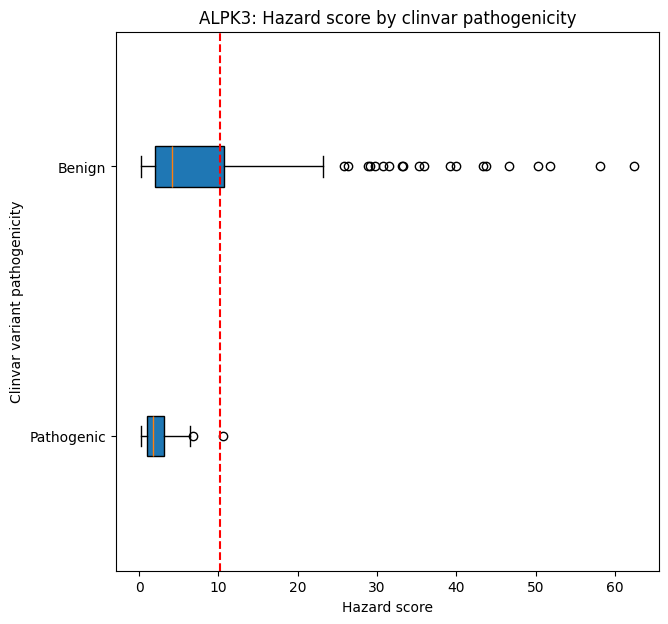

0.0196078431372549
0.002383080131069407


/var/folders/8_/3b98_7m10n32rvh6mgvypgj80000gn/T/ipykernel_77080/2218620000.py:15: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  clinvar_df = pd.read_csv("/Users/uriel/Downloads/work_temp/variant_summary.txt", sep = '\t')


FLNC


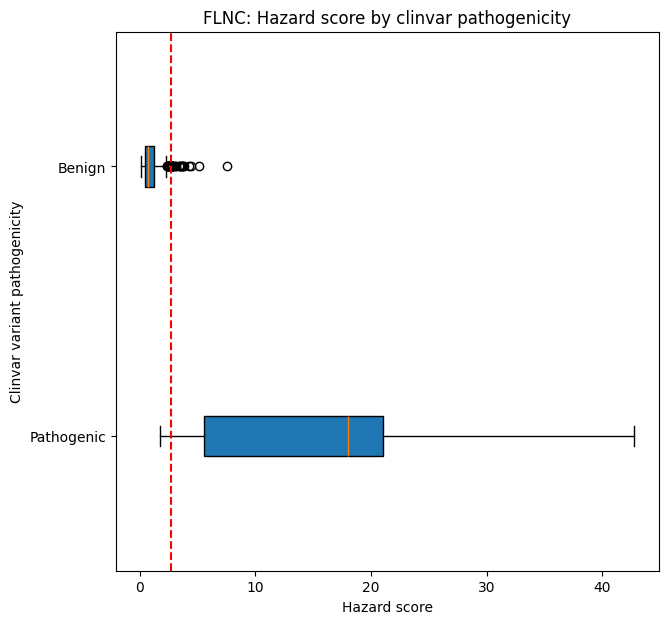

0.006278026905829596
0.002218770800976259


/var/folders/8_/3b98_7m10n32rvh6mgvypgj80000gn/T/ipykernel_77080/2218620000.py:15: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  clinvar_df = pd.read_csv("/Users/uriel/Downloads/work_temp/variant_summary.txt", sep = '\t')


MYBPC3


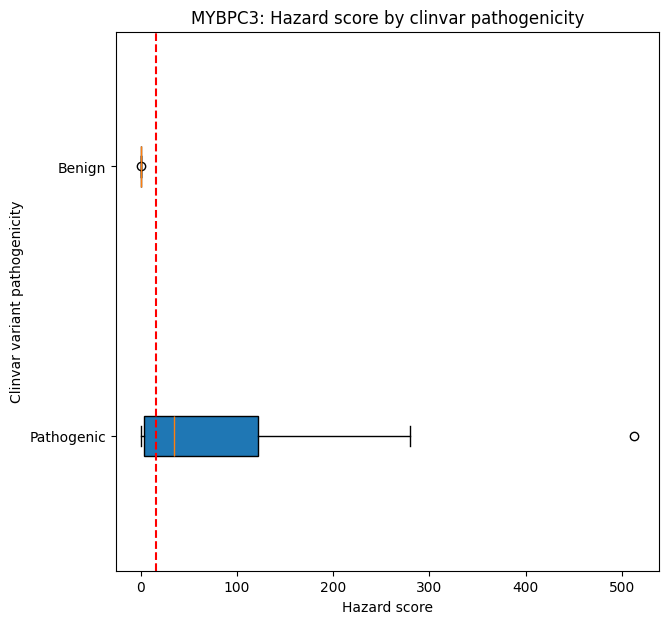

0.03896103896103896
0.004329572290737339


/var/folders/8_/3b98_7m10n32rvh6mgvypgj80000gn/T/ipykernel_77080/2218620000.py:15: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  clinvar_df = pd.read_csv("/Users/uriel/Downloads/work_temp/variant_summary.txt", sep = '\t')


MYH7


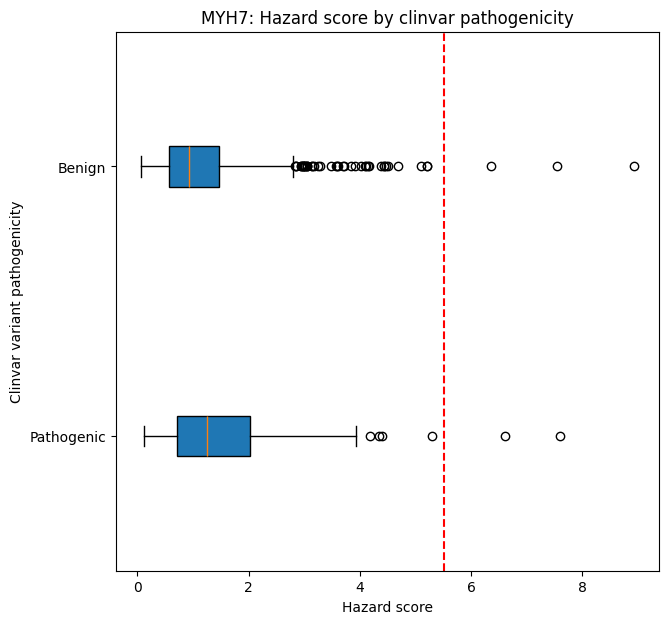

0.043478260869565216
0.009555555555555555


,P-value,Odds ratio,Thresholds
ALPK3,0.001305,10.756058,99
FLNC,0.000070,6.309641,89
MYBPC3,0.000008,18.890921,99
MYH7,0.000070,8.788962,98


In [222]:
updated_p_dict, hazard_ratios = find_threshold_vals(thresholds_by_hazard_score)
p_vals = pd.DataFrame.from_dict(updated_p_dict, orient = 'index')
p_vals.columns = ["P-value"]
hazard_ratios = pd.DataFrame.from_dict(hazard_ratios, orient = "index")
hazard_ratios.columns = ["Odds ratio"]
thresholds = pd.DataFrame.from_dict(thresholds_by_hazard_score, orient = 'index')
thresholds.columns = ["Thresholds"]
df = p_vals.join(hazard_ratios).join(thresholds)
df